<a href="https://colab.research.google.com/github/lightfury36/Data-Science/blob/master/Predicting_Churn_for_Telecom_Companies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
import warnings
warnings.filterwarnings('ignore')

import eli5
from eli5.sklearn import PermutationImportance

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import seaborn as sns
sns.set(palette='viridis_r',context='notebook',
        font='ubuntu', style='white')

from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold
from sklearn.ensemble import StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler


In [28]:
!pip install eli5


     |████████████████████████████████| 112kB 5.6MB/s 


In [13]:
from google.colab import files
uploaded = files.upload()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn.csv


In [14]:
df = pd.read_csv("/content/WA_Fn-UseC_-Telco-Customer-Churn.csv")

In [15]:
df.shape

(7043, 21)

In [16]:
#drop customer ID
train = df.drop(["customerID"], axis = 1)
train.head(5)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


##A Brief Exploratory Analysis##

In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [18]:
for column in train.drop(["tenure","MonthlyCharges","TotalCharges"], axis = 1):
    print(column, "-", train[column].unique())

gender - ['Female' 'Male']
SeniorCitizen - [0 1]
Partner - ['Yes' 'No']
Dependents - ['No' 'Yes']
PhoneService - ['No' 'Yes']
MultipleLines - ['No phone service' 'No' 'Yes']
InternetService - ['DSL' 'Fiber optic' 'No']
OnlineSecurity - ['No' 'Yes' 'No internet service']
OnlineBackup - ['Yes' 'No' 'No internet service']
DeviceProtection - ['No' 'Yes' 'No internet service']
TechSupport - ['No' 'Yes' 'No internet service']
StreamingTV - ['No' 'Yes' 'No internet service']
StreamingMovies - ['No' 'Yes' 'No internet service']
Contract - ['Month-to-month' 'One year' 'Two year']
PaperlessBilling - ['Yes' 'No']
PaymentMethod - ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn - ['No' 'Yes']


In [19]:
train.describe(include='object').T

,count,unique,top,freq
gender,7043,2,Male,3555
Partner,7043,2,No,3641
Dependents,7043,2,No,4933
PhoneService,7043,2,Yes,6361
MultipleLines,7043,3,No,3390
InternetService,7043,3,Fiber optic,3096
OnlineSecurity,7043,3,No,3498
OnlineBackup,7043,3,No,3088
DeviceProtection,7043,3,No,3095
TechSupport,7043,3,No,3473


In [20]:
train.TotalCharges = train.TotalCharges.apply(pd.to_numeric, errors='coerce')
train.TotalCharges = train.TotalCharges.fillna(train.TotalCharges.median())

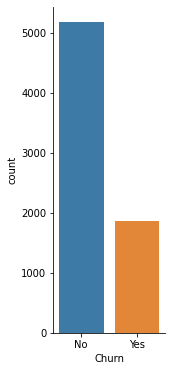

In [21]:
plt.figure(figsize=(2,6))
sns.countplot(x=train.Churn, alpha=0.95)
sns.despine()


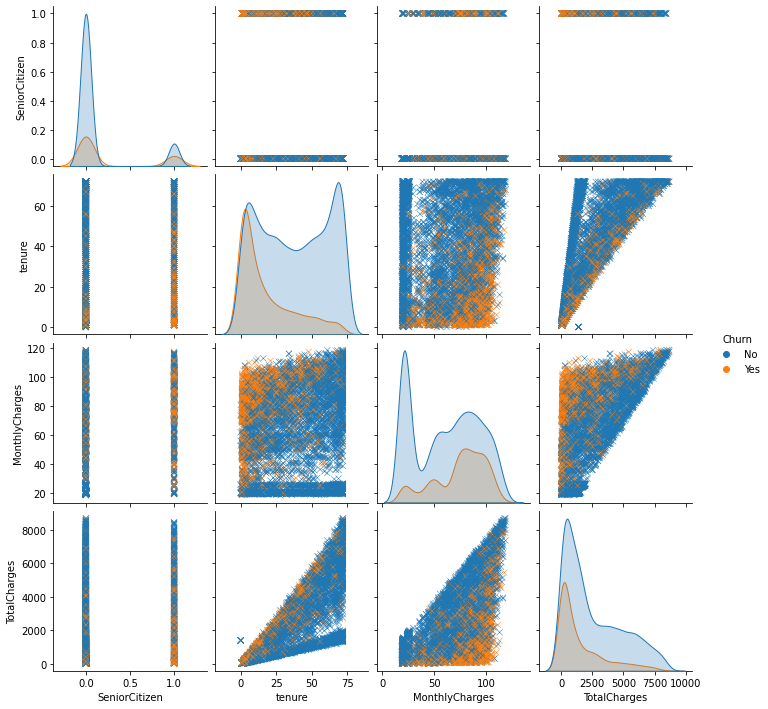

In [22]:
sns.pairplot(train, hue='Churn', markers='x')

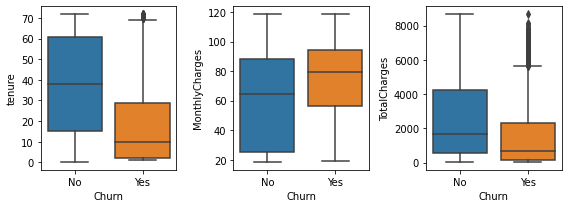

In [23]:
fig, axes = plt.subplots(ncols=3, figsize=(8,3))

sample = train[["tenure", "MonthlyCharges", "TotalCharges"]]

for ax,column in zip(axes.ravel(), sample):
    sns.boxplot(x=train.Churn, y=train[column], ax=ax)

plt.tight_layout()


Non-surprisingly, churned have a lower median tenure than a non-churned. But they are much higher in terms of MontlyCharges and spend lesser money in total.

So, there could be some insights from tenure & monthly charges.

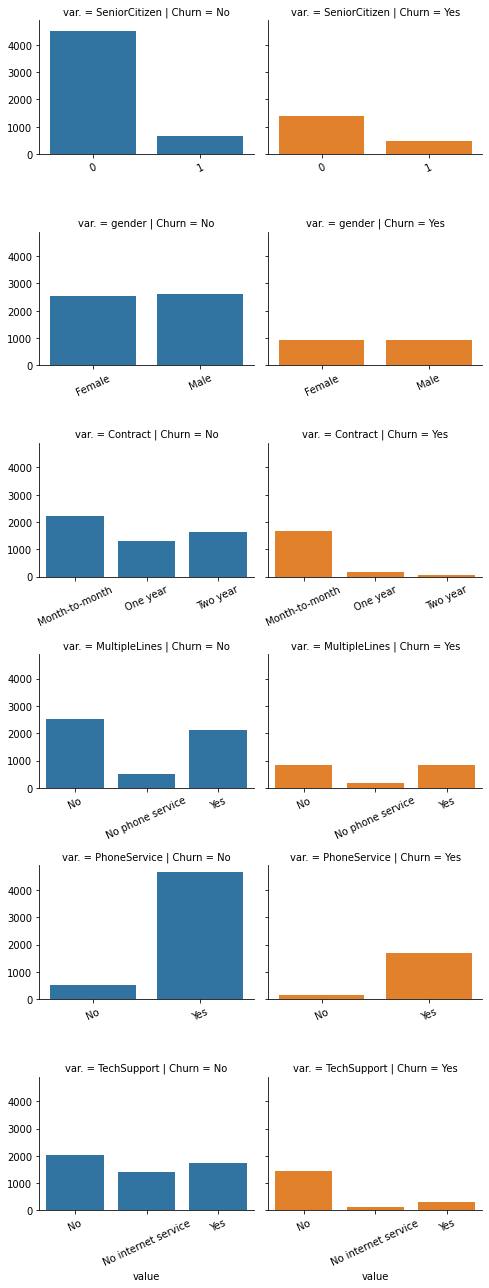

In [24]:
import warnings
warnings.filterwarnings('ignore')

melted = pd.melt(train, id_vars=['Churn'], value_vars = ['gender', 'SeniorCitizen',
        'Contract','PhoneService','MultipleLines','TechSupport'])
melted = melted.sort_values(['value','variable']).rename(
                            columns={'variable':'var.'})

g = sns.FacetGrid(melted, col='Churn', row='var.', aspect=1.15,
                  hue = 'Churn',sharex=False)
g.map(sns.countplot, 'value')

g.set_xticklabels(rotation=25)
plt.tight_layout()

It also looks like that those who have no internet service on Tech Support are at the group of risk.

Type of contact could also have a significant meaning to Churn. It is interesting to look at Month-to-Month Contracts closely.

##Preprocessing the Data##


I would take a transition from categorical values to scaled features by using some steps to further prediction

1. Scaling of non-bool values like tenure,TotalCharges,Monthly Charges with a help of MinMaxScaler
2. Encode categorical values with  >2  choices and redistribute them as a new binary feature (with OneHotEncoder).
3.Transform categorical values with binary choice to [0,1] view

In [30]:
train2 = train.copy()

lec = LabelEncoder()

train2.loc[:,'gender':'Dependents']=train2.loc[:,'gender':'Dependents'].transform(lec.fit_transform)
train2.loc[:,'PhoneService':'PaymentMethod']=train2.loc[:,'PhoneService':'PaymentMethod'].\
transform(lec.fit_transform)
train2['Churn'] = lec.fit_transform(train2['Churn'])

mms = MinMaxScaler()
train2[['tenure','MonthlyCharges','TotalCharges']] =\
mms.fit_transform(train2[['tenure','MonthlyCharges','TotalCharges']])

findfont: Font family ['ubuntu'] not found. Falling back to DejaVu Sans.
findfont: Font family ['ubuntu'] not found. Falling back to DejaVu Sans.


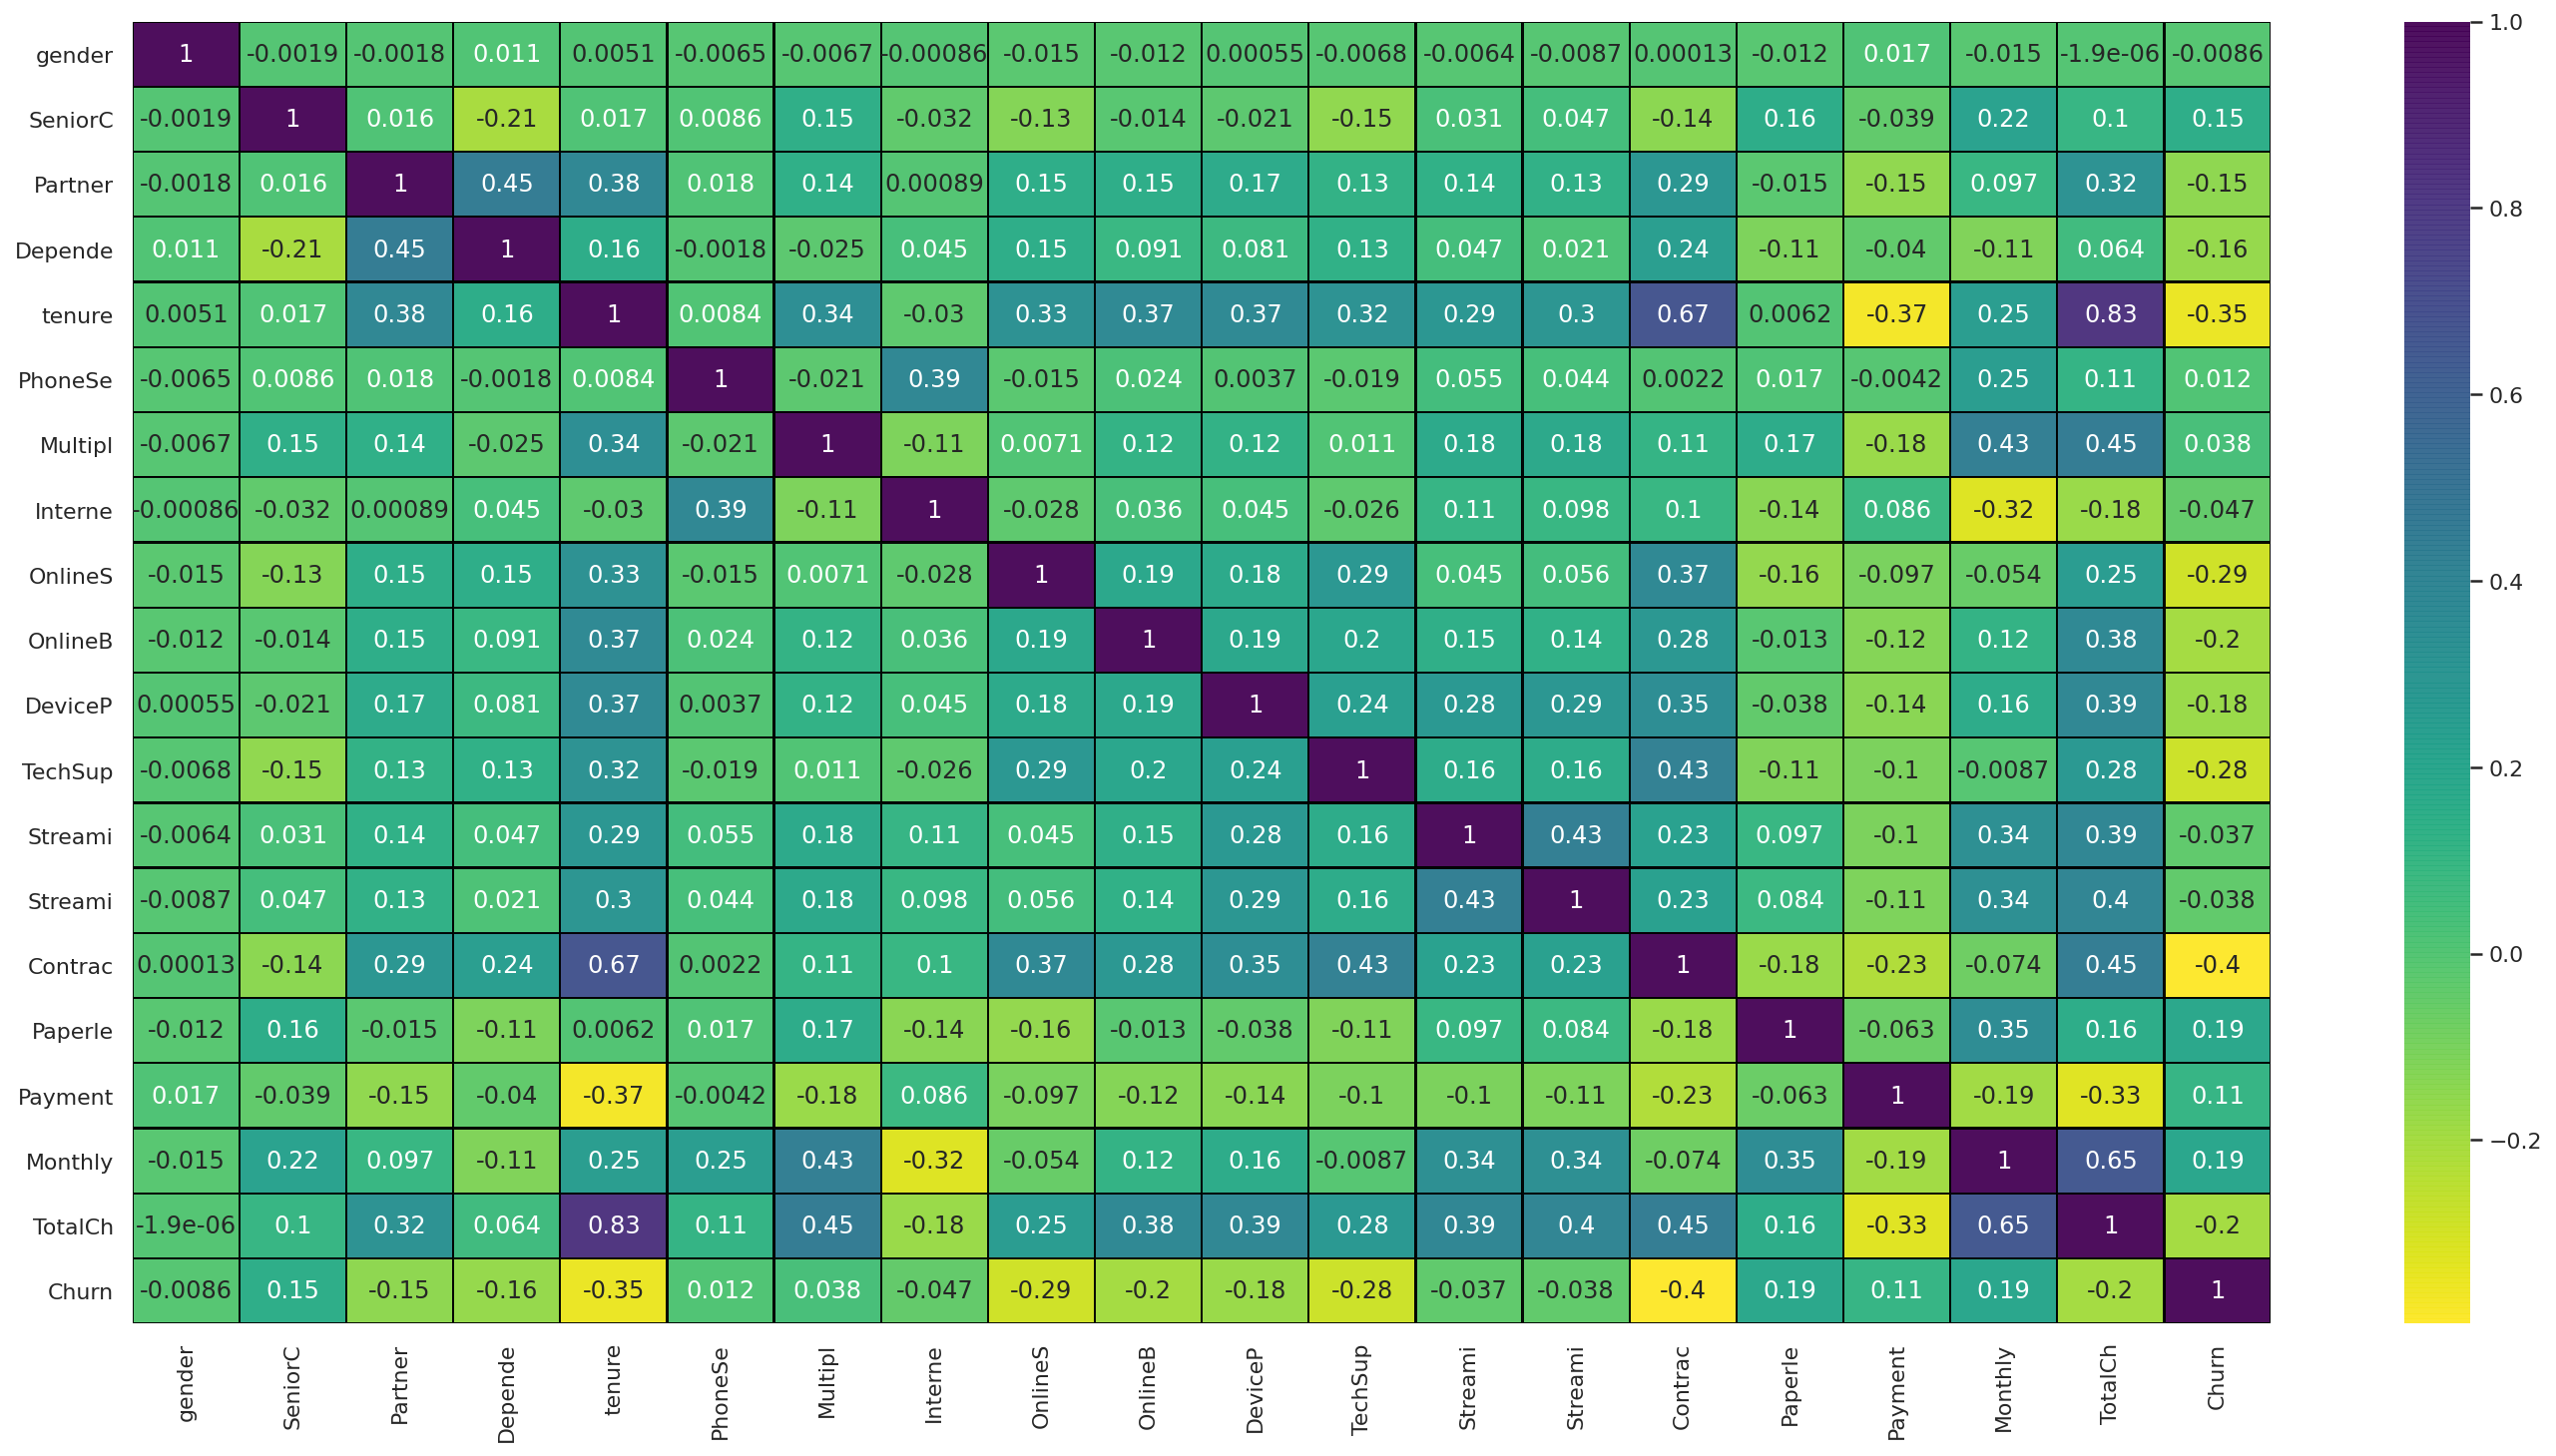

In [31]:
features = train2.loc[:,'gender':'TotalCharges']
target = train2['Churn']

fig = plt.figure(figsize=(24,12))
ax = sns.heatmap(train2.corr(), cmap='viridis_r',
      linecolor='black', lw=.65,annot=True, alpha=.95)
ax.set_xticklabels([x[:7] for x in train2.columns])
ax.set_yticklabels([y[:7] for y in train2.columns])

plt.show()

The dataset is imbalanced. That is why I wouldn't use ROC AUC score as a primary metric (but for some reasons, I will caluclate it as an additional one).

For this task of churn classification accuracy score is used.

##Model Selection & Prediction##

In [32]:
X_train, X_valid, y_train, y_valid = train_test_split(
    features, target,test_size=.2,random_state=42)

gbc = GradientBoostingClassifier(random_state=42)
rfc = RandomForestClassifier(random_state=42,min_samples_leaf=30)
svc = SVC(random_state=42,degree=3)
lgc = LogisticRegression(random_state=42)
knn = KNeighborsClassifier(n_jobs=5)

estimators = [('Random Forest Classifier',rfc),
              ('Support Vector Machines',svc),
              ('Logistic Regression',lgc), 
              ('Gradient Boosting Classifier',gbc),
              ('KNN Classifier',knn)]

In [33]:
def confusion_plot(label, y_valid, y_pred, ax=None):
    
    co_ma = confusion_matrix(y_valid, y_pred)
    groups = ['True Neg','False Pos','False Neg','True Pos']
    counts = [int(value) for value in co_ma.flatten()]
    shares = ['{0:.2%}'.format(value) for value in
             co_ma.flatten()/np.sum(co_ma)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(groups,counts,shares)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(co_ma,annot=labels,cmap='binary', alpha=.55, ax=ax,
             cbar=True, fmt='', linewidth=1,linecolor='black')
    plt.title(f'Confusion Matrix for {label}')

                                            
def show_metrics(metrics):
    try:return pd.DataFrame(metrics)
    except:return pd.DataFrame([metrics])

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


,classifier,accuracy_score,roc_auc_score,f1_score
0,Random Forest Classifier,0.809794,0.707664,0.577287
1,Support Vector Machines,0.804116,0.704660,0.571429
2,Logistic Regression,0.816182,0.740316,0.625181
3,Gradient Boosting Classifier,0.805536,0.714204,0.586103
4,KNN Classifier,0.768630,0.685676,0.538244


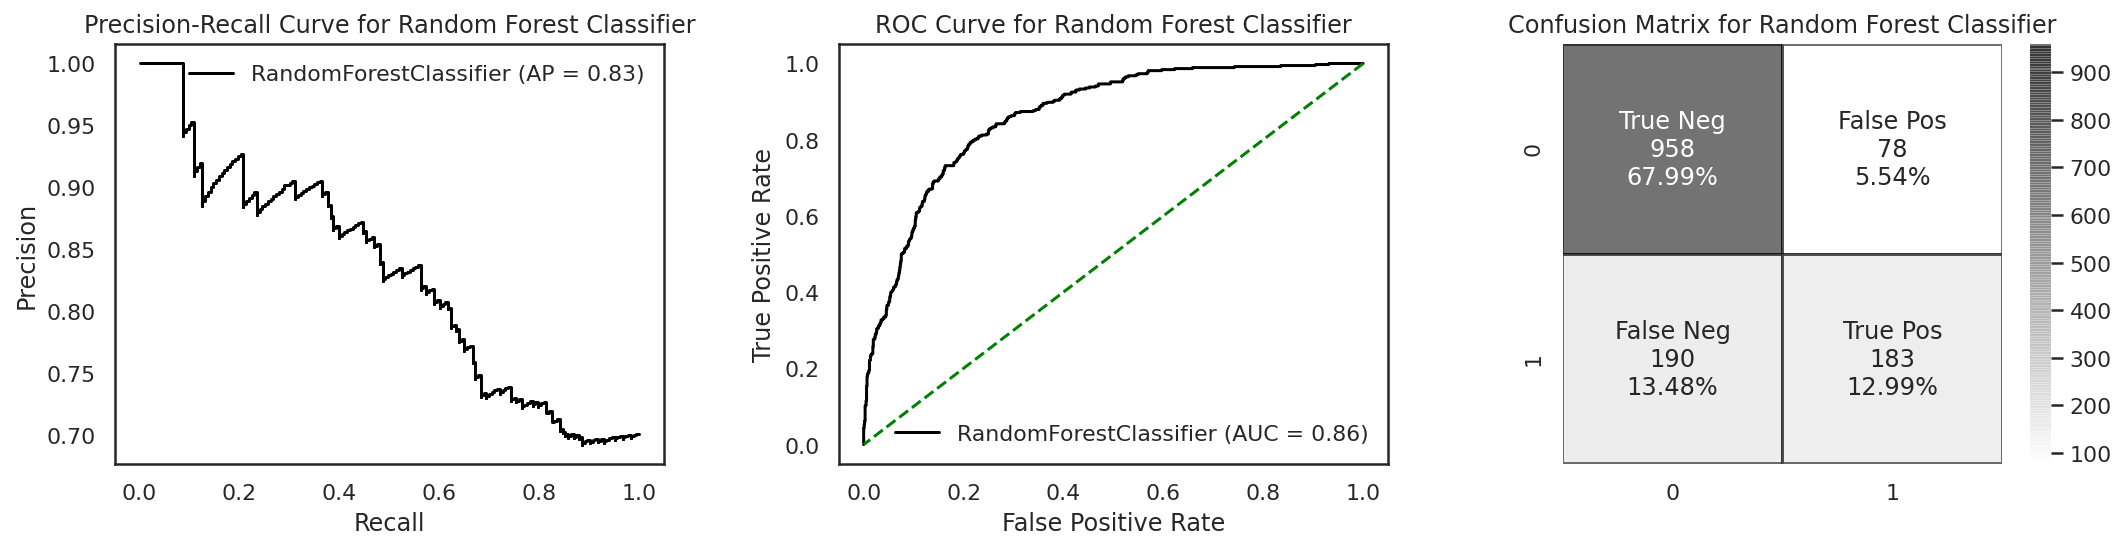

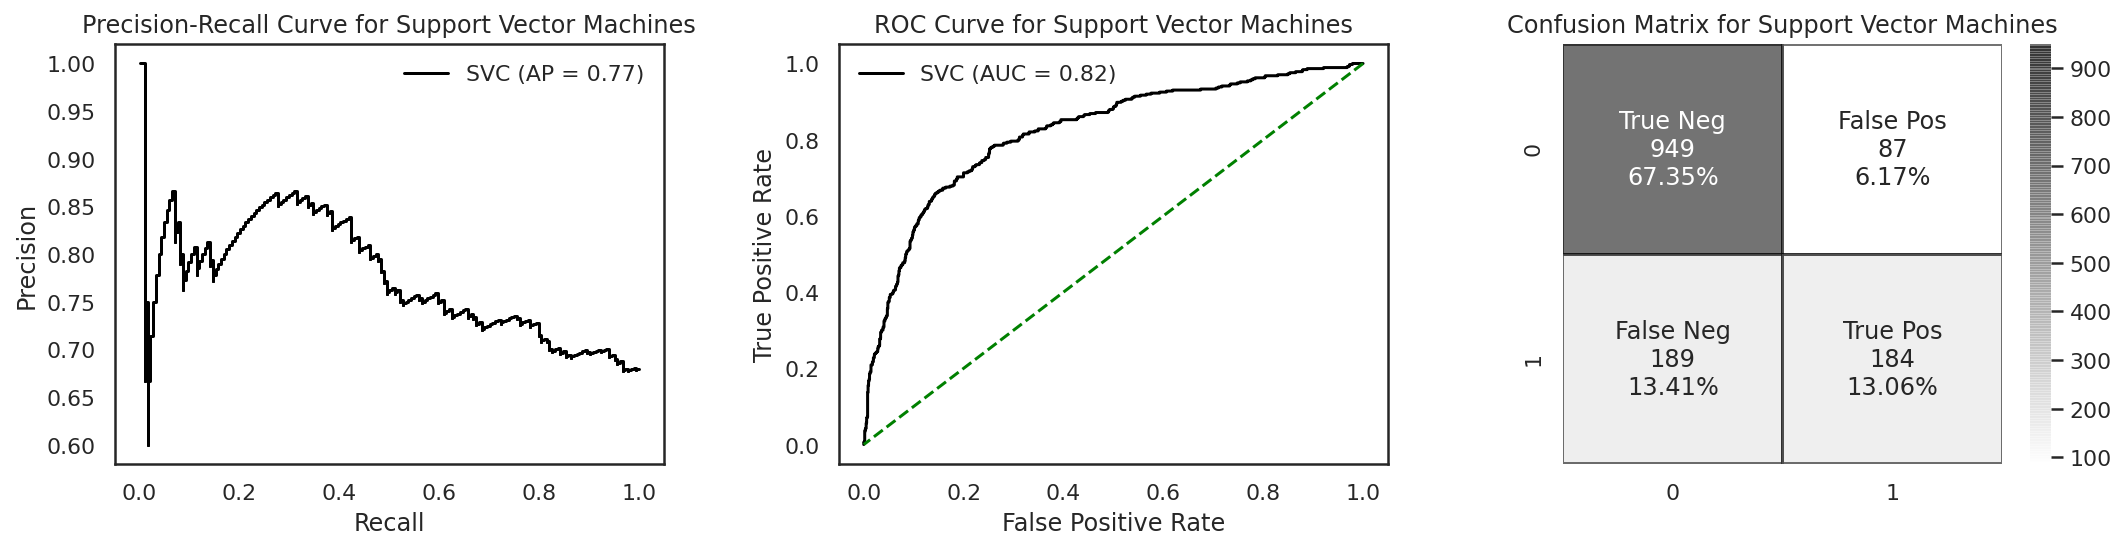

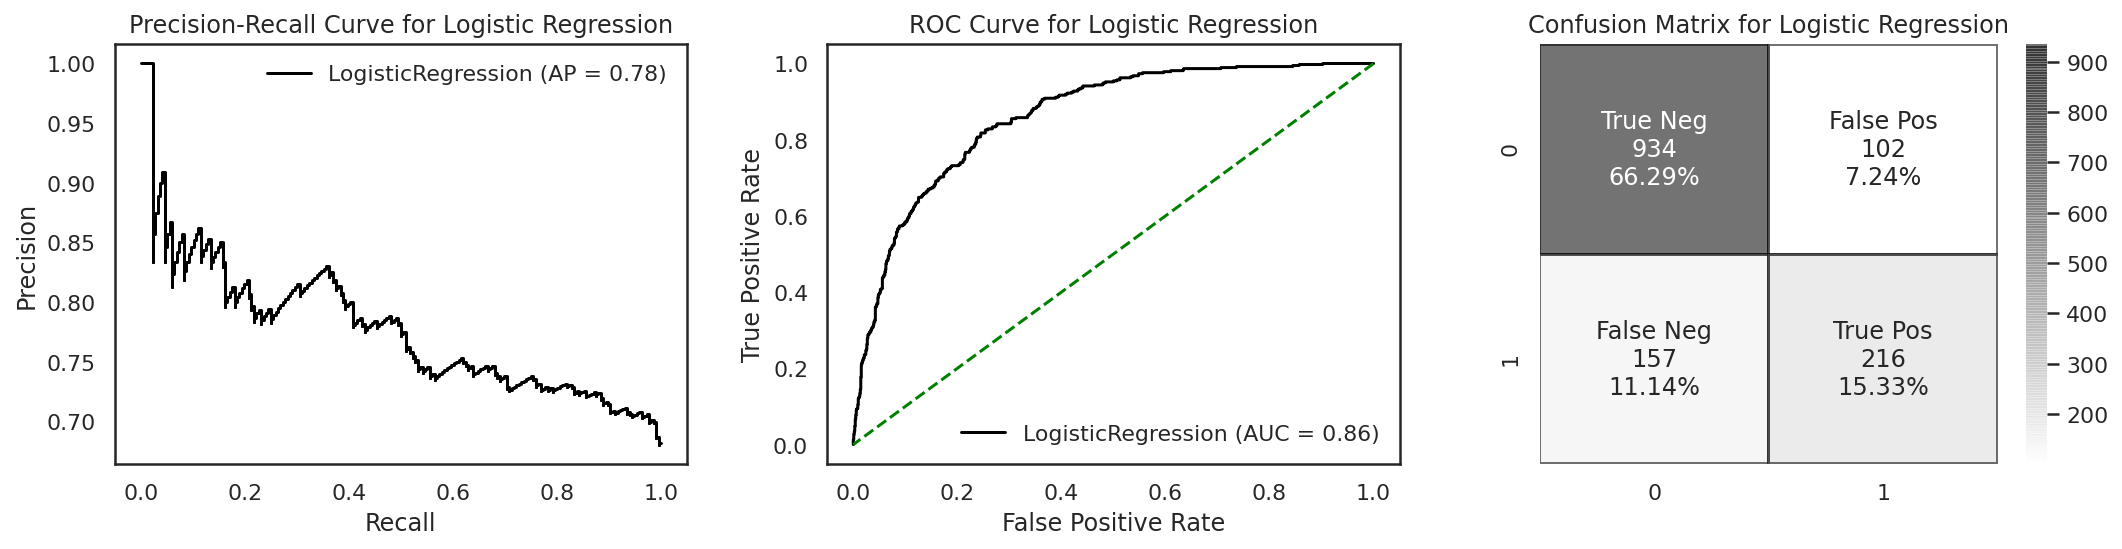

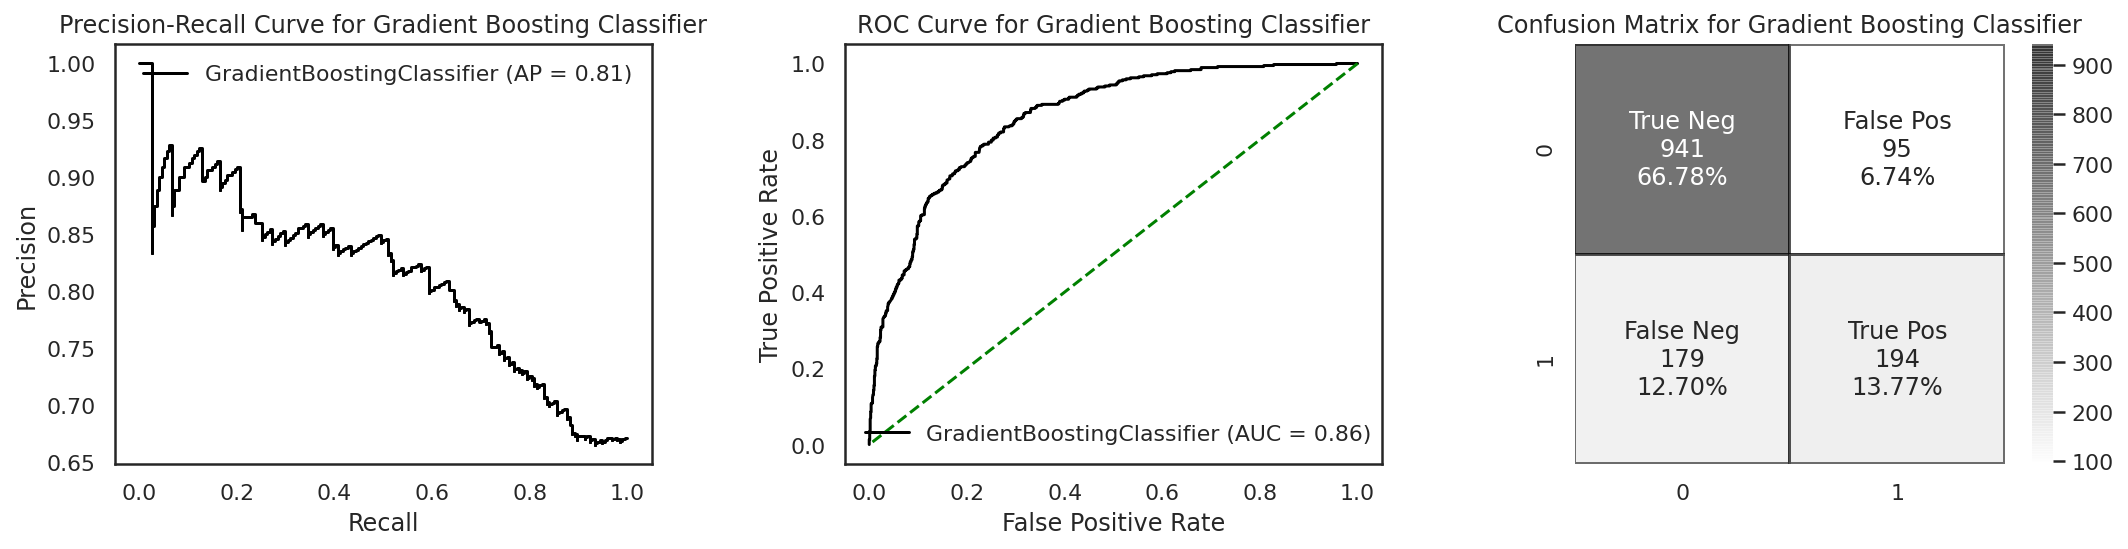

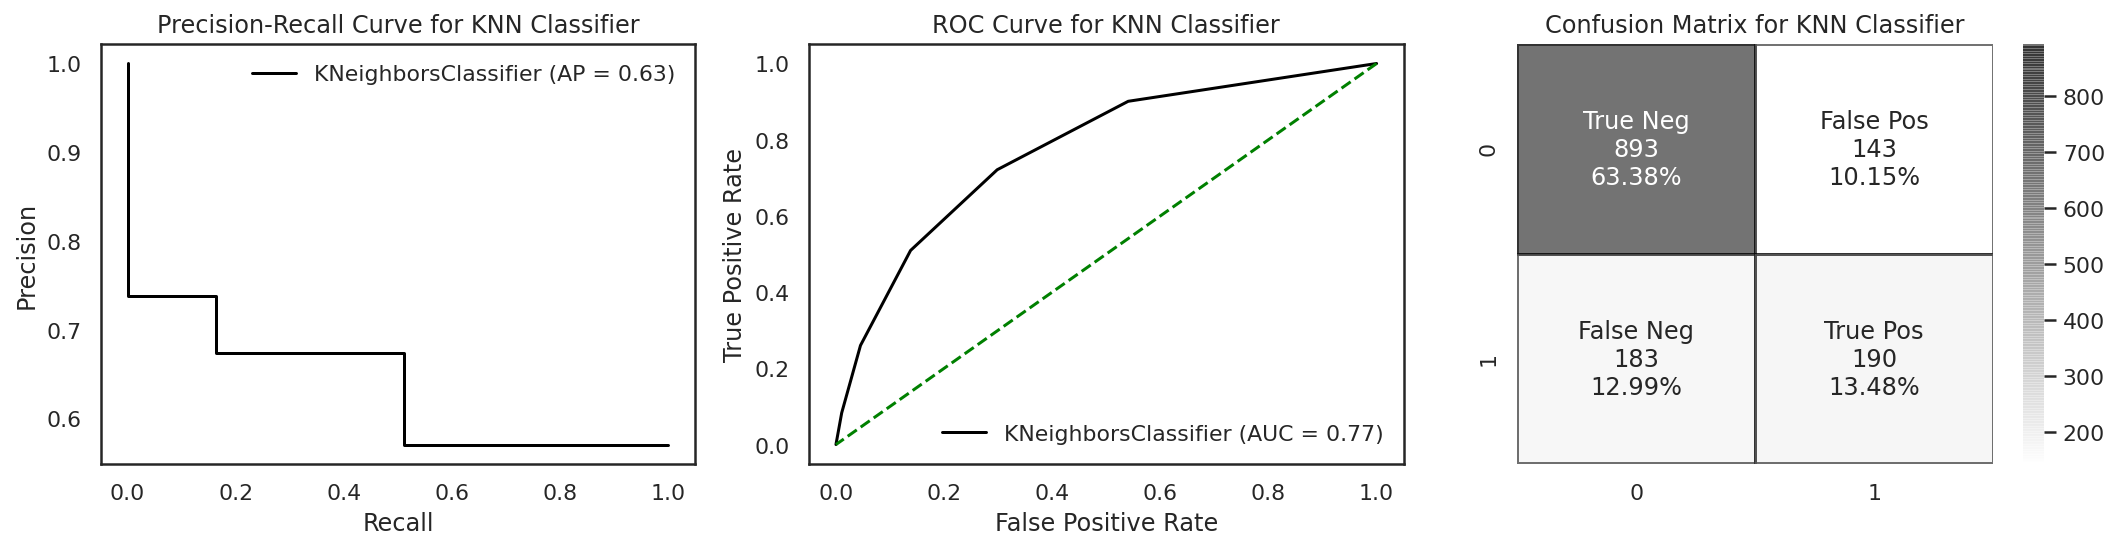

In [34]:
metrics = []

for est in estimators:
    
    fig, axes = plt.subplots(ncols=3, figsize=(15,4))
   
    mod = est[1].fit(X_train, y_train)
    y_pred = mod.predict(X_valid)
    plot_precision_recall_curve(mod, X_valid, y_valid, 
                    y_pred, ax=axes[0], color='black')
    plot_roc_curve(mod, X_valid, y_valid,ax = axes[1], color='black')

    axes[0].set_title(f'Precision-Recall Curve for {est[0]}')
    axes[1].set_title(f'ROC Curve for {est[0]}')
    axes[1].plot([1,0],[1,0], c='green',ls='--')
    confusion_plot(est[0],y_valid, y_pred, axes[2])
    for ax in axes.ravel():
        ax.legend(frameon=False)
        
    scores = {}
    scores['classifier'] = est[0]
    scores['accuracy_score'] = accuracy_score(y_valid, y_pred)
    scores['roc_auc_score']=roc_auc_score(y_valid, y_pred)
    scores['f1_score'] = f1_score(y_valid,y_pred)

    plt.tight_layout()
    metrics.append(scores)

show_metrics(metrics)

No handles with labels found to put in legend.


,classifier,accuracy_score,ROC AUC score,f1_score
0,Stacking Classifier,0.818311,0.734044,0.61791


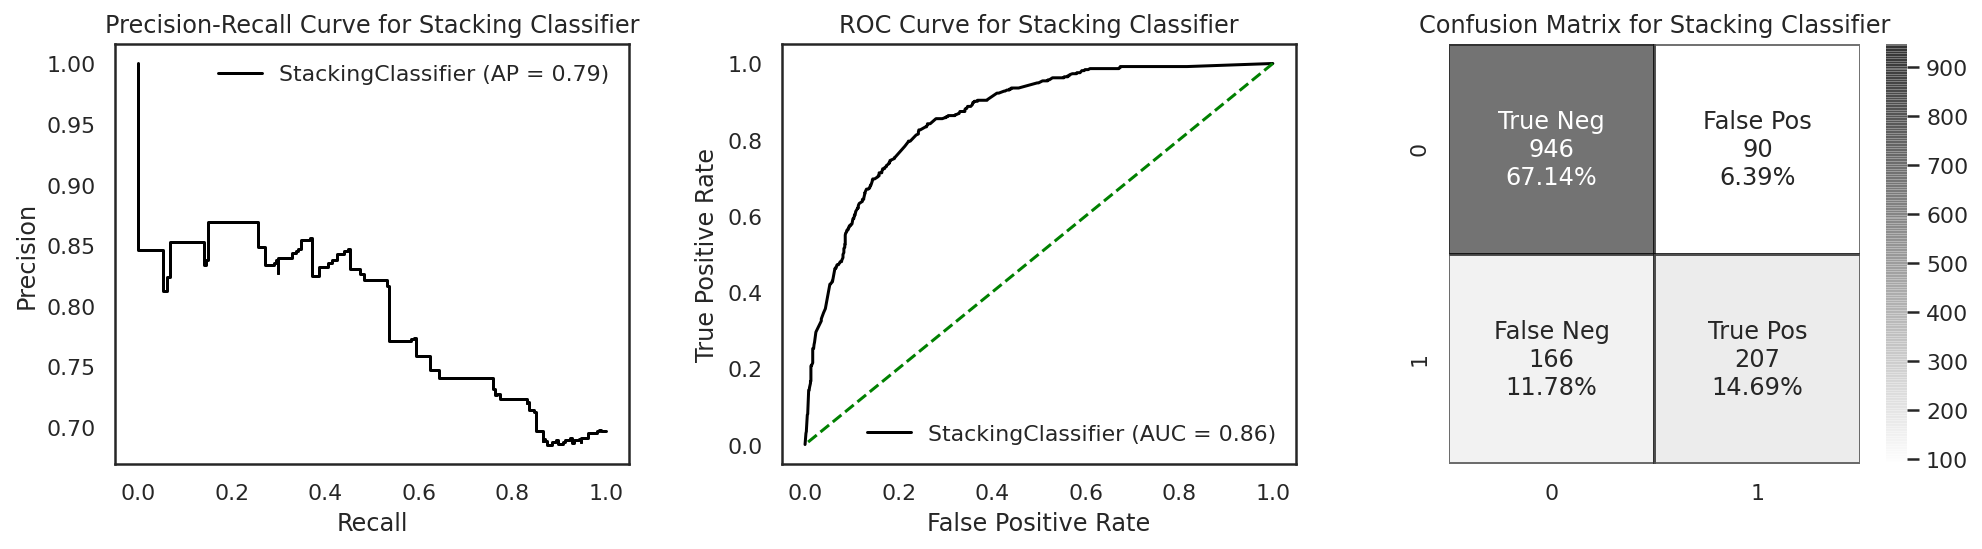

In [35]:
params={'colsample_bytree': 0.6, 'gamma': 5, 'max_depth': 3, 'min_child_weight': 5.0, 'subsample': 1.0}


xgb = XGBClassifier(random_state=42,
                    **params,cv=5, verbosity=0)

stacked_metrics={}

reg = StackingClassifier(estimators=estimators,
    final_estimator=xgb)
cls_name = 'Stacking Classifier'

regmodel = reg.fit(X_train, y_train)
y_pred = reg.predict(X_valid)

fig, axes = plt.subplots(ncols=3, figsize=(14,4))

plot_precision_recall_curve(regmodel,X_valid,y_valid, 
            y_pred, color='black', ax=axes[0])
plot_roc_curve(regmodel,X_valid,y_valid, 
               color='black', ax=axes[1])

axes[0].set_title(f'Precision-Recall Curve for {cls_name}')
axes[1].plot([1,0],[1,0], c='green',ls='--')
axes[1].set_title(f'ROC Curve for {cls_name}')
confusion_plot(cls_name,y_valid, y_pred, axes[2])
for ax in axes:
    ax.legend(frameon=False)

stacked_metrics['classifier'] = cls_name
stacked_metrics['accuracy_score'] = accuracy_score(y_valid, y_pred)
stacked_metrics['ROC AUC score'] = roc_auc_score(y_valid, y_pred)
stacked_metrics['f1_score'] = f1_score(y_valid, y_pred)
    
plt.tight_layout()

pd.DataFrame([stacked_metrics])

In [36]:
perm = PermutationImportance(regmodel,random_state=17).fit(X_valid,y_valid)
eli5.show_weights(perm, feature_names=X_valid.columns.values)

Weight,Feature
0.0480 ± 0.0063,tenure
0.0349 ± 0.0101,MonthlyCharges
0.0335 ± 0.0079,Contract
0.0104 ± 0.0081,PaperlessBilling
0.0098 ± 0.0050,InternetService
0.0068 ± 0.0044,PaymentMethod
0.0065 ± 0.0085,OnlineSecurity
0.0051 ± 0.0036,PhoneService
0.0051 ± 0.0019,StreamingMovies
0.0045 ± 0.0046,MultipleLines


A stacked model has accuracy score of  0.811923 ... after a grid search and can be used for predictions.